In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
#euclidean distance
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

Implementing the $G_\epsilon$ score for trade off measurements. 
The score is given by :
$$ G_\epsilon = \alpha \mu(D_{s},D_{p})+\beta \delta( D_{s},D_{p})$$
where
$$\mu (D_{s},D_{p})= \dfrac{\left || \Phi_{k}(D_{s})-\Phi_{k}(D_{p})\right||_{2}}{m(m-1)/2} $$
$$ \delta(D_{s},D_{p})= \dfrac {1}{mKL} \sum _{m}\sum_{K} \sum_{L} || acc^{l}(M_{X_{i},D_{s}}^{k})-acc^{l}(M_{X_{i},D_{p}}^{k})  ||_{2}$$

Implementing $\Phi_{k}$ correlation index at first

In [2]:
import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix
from phik import report

In [14]:
#Toy data with Iris original and synthetic dataset
D_p=pd.read_csv('Project/DataSets/Data_Adult/adult_original.csv')
# D_p.drop('Unnamed: 0',axis=1,inplace=True)
D_s=pd.read_csv('Project/DataSets/Data_Adult/non_param_Copulas_samples.csv')
D_s.drop('Unnamed: 0',axis=1,inplace=True)
data=D_p.copy()

In [3]:
Dp=pd.read_csv('Project/DataSets/Data_Iris/iris.csv')
Dp.drop(['Unnamed: 0'], axis=1, inplace=True)
data_types = {'sepal_length': 'interval', 
              'sepal_width': 'interval', 
              'petal_length': 'interval', 
              'petal_width': 'interval',
              'species': 'categorical'}
interval_cols = [col for col, v in data_types.items() if v=='interval' and col in Dp.columns]
categorical_cols = [col for col, v in data_types.items() if v=='categorical' and col in Dp.columns]

In [15]:
data_types = {'age': 'interval',
    'workclass': 'categorical',
    'fnlwgt': 'interval',
    'education': 'categorical',
    'education-num': 'interval',
    'marital-status': 'categorical',
    'occupation': 'categorical',
    'relationship': 'categorical',
    'race': 'categorical',
    'sex': 'categorical',
    'capital-gain': 'interval',
    'capital-loss': 'interval',
    'hours-per-week': 'interval',
    'native-country': 'categorical',
    'label': 'categorical'}
interval_cols = [col for col, v in data_types.items() if v=='interval' and col in data.columns]
categorical_cols = [col for col, v in data_types.items() if v=='categorical' and col in data.columns]

In [4]:
phik_DS = Dp.phik_matrix(interval_cols=interval_cols)

Getting $\mu (D_{s},D_{p})$

In [6]:
def get_mu(Ds,Dp, categorical_cols,interval_cols,data_type):
    #Getting correlation matrix
    phik_DS = Ds.phik_matrix(interval_cols=interval_cols)
    phik_DP = Dp.phik_matrix(interval_cols=interval_cols)
    plot_correlation_matrix(phik_DS.values, x_labels=phik_DS.columns, y_labels=phik_DS.index, 
                        vmin=0, vmax=1, color_map='Reds', title=r'correlation $\phi_K (D_{s})$',
                        figsize=(7,5.5))
    plt.tight_layout()
    plt.show

    plot_correlation_matrix(phik_DP.values, x_labels=phik_DP.columns, y_labels=phik_DP.index, 
                            vmin=0, vmax=1, color_map='Reds', title=r'correlation $\phi_K (D_{p})$',
                            figsize=(7,5.5))
    plt.tight_layout()
    plt.show()
    
    #euclidean norm of the difference between the two matrices
    diff = np.linalg.norm(phik_DS-phik_DP)
    m=phik_DS.shape[0]
    mu = diff/(m*(m-1)/2)
    print(f'The mu is: {mu}')
    return mu
    

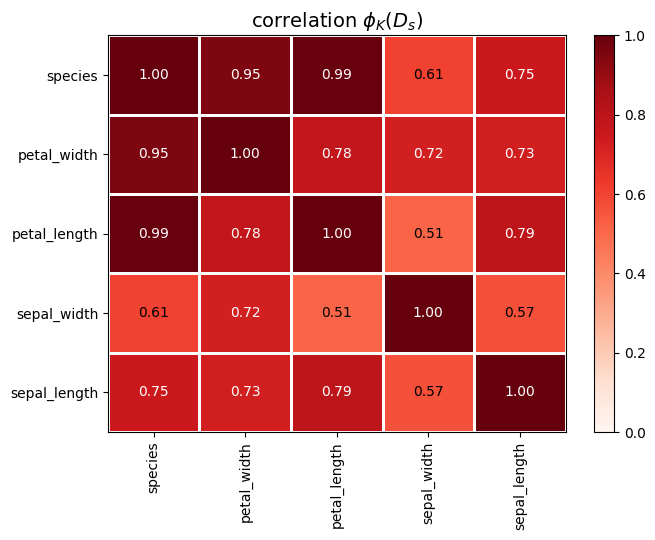

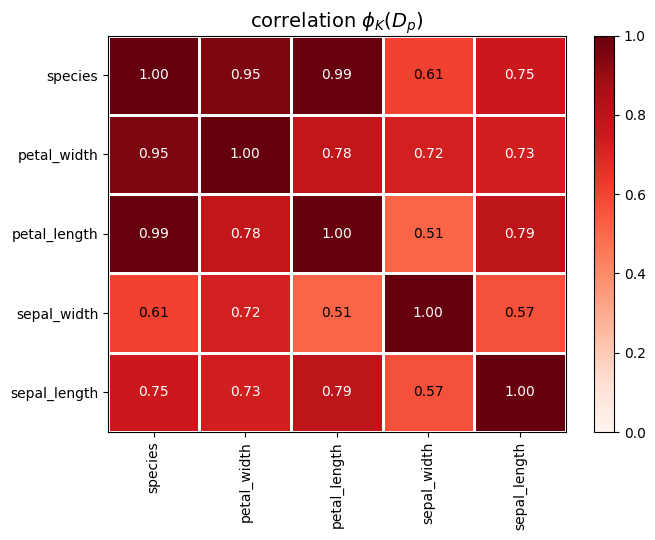

The mu is: 0.0


0.0

In [8]:
get_mu(Dp,Dp,categorical_cols,interval_cols,data_types)

In [9]:
from Project.Metrics.Utility.utility import DataPreProcessor
from Project.Metrics.Utility.utility import train_evaluate_model
from Project.Metrics.Utility.utility_regressor import DataPreProcessor_regressor
from Project.Metrics.Utility.utility_regressor import train_evaluate_model_regressor

Getting $\delta (D_{p},D_{s})$

In [13]:
#Making a function to get delta for a Dataset D getting bot, the classification an regressor score
def get_utility_matrix(D, categorical_cols, interval_cols, data_types):
    
    # m is the number of ML tasks (features in this scenario)
    # K is the number ML models (Classification models)
    # L is the number of scoring functions

    #Using the class from https://github.com/Vicomtech/STDG-evaluation-metrics (By Mikel Hernandez)
    #l = {accuracy,precision,recall,f1,roc_auc}
    #K = {DT,KNN,MLP,RF,SVM}

    #For categorical columns
    #Initialize a 3D matrix with mxKxL
    K_c = 5
    L_c = 4
    m_c = len(categorical_cols)
    matrix_c = np.zeros((K_c,L_c,m_c))
    #Getting a sample of 80% of the data
    data_train = D.sample(frac=0.8, random_state=1)
    data_test = D.drop(data_train.index)

    #only iterate over the categorical columns
    for id,i in enumerate(categorical_cols):
        #The i-th Ml task corresponds to the i-th column in the dataset, 
        #and the label for prediction 
        target_col = i
        model_cols = [col for col in data.columns if col != target_col]
        #new categorical and numerical cols without the target value
        interval_cols_ = [col for col, v in data_types.items() if v=='interval' and col != target_col]
        categorical_cols_ = [col for col, v in data_types.items() if v=='categorical' and col != target_col]

        if len(categorical_cols_) == 0:
            categorical_cols_ = None
        if len(interval_cols_) == 0:
            interval_cols_ = None
        print(f'Model cols: {model_cols}')
        
        print(f'Target column: {target_col}')
        #Model cols are every column except the target column
        categories = [np.array(range(len(data[col].unique()))) for col in categorical_cols_]
    
        data_preprocessor = DataPreProcessor(categorical_cols_, interval_cols_,
                                            categories)
        
        x_train = data_preprocessor.preprocess_train_data(data_train.loc[:, model_cols])
        y_train = data_train.loc[:, target_col]
        
        x_test = data_preprocessor.preprocess_test_data(data_test.loc[:, model_cols])
        y_test = data_test.loc[:, target_col]
        
        #training RF
        print('Training RF')
        rf_results = train_evaluate_model('RF', x_train, y_train, x_test, y_test)
        rf_results.drop('model',axis=1,inplace=True)
        print(rf_results)
        #training kN
        print('Training KNN')
        knn_results = train_evaluate_model('KNN', x_train, y_train, x_test, y_test)
        knn_results.drop('model',axis=1,inplace=True)
        #training DT
        print('Training DT')
        dt_results = train_evaluate_model('DT', x_train, y_train, x_test, y_test)
        dt_results.drop('model',axis=1,inplace=True)
        #training SVM
        print('Training SVM')
        svm_results = train_evaluate_model('SVM', x_train, y_train, x_test, y_test)
        svm_results.drop('model',axis=1,inplace=True)
        #training MLP
        print('Training MLP')
        mlp_results = train_evaluate_model('MLP', x_train, y_train, x_test, y_test)
        mlp_results.drop('model',axis=1,inplace=True)
        matrix_c[0,:,id]=rf_results.values
        matrix_c[1,:,id]=knn_results.values
        matrix_c[2,:,id]=dt_results.values
        matrix_c[3,:,id]=svm_results.values
        matrix_c[4,:,id]=mlp_results.values
        
          
    # m is the number of ML tasks (features in this scenario)
    # K is the number ML models (Regressor models)
    # L is the number of scoring functions

    #Using the class from https://github.com/Vicomtech/STDG-evaluation-metrics (By Mikel Hernandez)
    #l = {mean_absolute_error,mean_squared_error,r2}
    #K = {'SVR','RandomForestRegressor','KNeighborsRegressor','MLPRegressor','DecisionTreeRegressor'}


    #For interval columns
    #Initialize a 3D matrix with mxKxL
    K_r = 5
    L_r = 3
    m_r= len(interval_cols)
    matrix_r = np.zeros((K_r,L_r,m_r))
    #Getting a sample of 80% of the data

    #only iterate over the categorical columns
    for id,i in enumerate(interval_cols):
        #The i-th Ml task corresponds to the i-th column in the dataset, 
        #and the label for prediction 
        target_col = i
        model_cols = [col for col in data.columns if col != target_col]
        #new categorical and numerical cols without the target value
        interval_cols_ = [col for col, v in data_types.items() if v=='interval' and col != target_col]
        categorical_cols_ = [col for col, v in data_types.items() if v=='categorical' and col != target_col]

        if len(categorical_cols_) == 0:
            categorical_cols_ = None
        if len(interval_cols_) == 0:
            interval_cols_ = None
            
        print(f'Model cols: {model_cols}')
        print(f'Target column: {target_col}')
        
        #Model cols are every column except the target column
        categories = [np.array(range(len(data[col].unique()))) for col in categorical_cols_]
    
        data_preprocessor = DataPreProcessor(categorical_cols_, interval_cols_,
                                            categories)
        
        x_train = data_preprocessor.preprocess_train_data(data_train.loc[:, model_cols])
        y_train = data_train.loc[:, target_col]
        
        x_test = data_preprocessor.preprocess_test_data(data_test.loc[:, model_cols])
        y_test = data_test.loc[:, target_col]
        
        #training SVR
        print('Training SVR')
        svr_results = train_evaluate_model_regressor('SVR', x_train, y_train, x_test, y_test)
        svr_results.drop('Model',axis=1,inplace=True)
        print(svr_results)
        #training RandomForestRegressor
        print('Training RandomForestRegressor')
        rf_results = train_evaluate_model_regressor('RandomForestRegressor', x_train, y_train, x_test, y_test)
        rf_results.drop('Model',axis=1,inplace=True)
        print(rf_results)
        #training KNeighborsRegressor
        print('Training KNeighborsRegressor')
        knn_results = train_evaluate_model_regressor('KNeighborsRegressor', x_train, y_train, x_test, y_test)
        knn_results.drop('Model',axis=1,inplace=True)
        print(knn_results)
        #training DecisionTreeRegressor
        print('Training DecisionTreeRegressor')
        dt_results = train_evaluate_model_regressor('DecisionTreeRegressor', x_train, y_train, x_test, y_test)
        dt_results.drop('Model',axis=1,inplace=True)
        print(dt_results)
        #training MLPRegressor
        print('Training MLPRegressor')
        mlp_results = train_evaluate_model_regressor('MLPRegressor', x_train, y_train, x_test, y_test)
        mlp_results.drop('Model',axis=1,inplace=True)
        print(mlp_results)
        matrix_r[0,:,id]=svr_results.values
        matrix_r[1,:,id]=rf_results.values
        matrix_r[2,:,id]=knn_results.values
        matrix_r[3,:,id]=dt_results.values
        matrix_r[4,:,id]=mlp_results.values
        
    return matrix_c, matrix_r

def get_delta(Ds,Dp,data_types,categorical_cols,interval_cols):
    #Getting the utility matrix for the synthetic dataset
    matrix_Ds_c, matrix_Ds_r = get_utility_matrix(Ds, categorical_cols, interval_cols, data_types)
    #Getting the utility matrix for the original dataset
    matrix_Dp_c, matrix_Dp_r = get_utility_matrix(Dp, categorical_cols, interval_cols, data_types)
    
    #For delta_regressor
    K_r,L_r,m_r,  = matrix_Ds_r.shape
    summ=0
    for m in range(m_r):
        sumk=0
        for k in range(K_r):
            sumL=0
            for l in range(L_r):
                sumL+=euclidean_distance(matrix_Ds_r[k,l,m],matrix_Dp_r[k,l,m])
            sumk+=sumL
        summ+=sumk
        
    delta_l = (1/(m_r*K_r*L_r))*summ 
    print(f'delta value is {delta_l}')
    
    #For delta classifier
    K_c,L_c,m_c,  = matrix_Ds_c.shape
    summ=0  
    for m in range(m_c):
        sumk=0
        for k in range(K_c):
            sumL=0
            for l in range(L_c):
                sumL+=euclidean_distance(matrix_Ds_c[k,l,m],matrix_Dp_c[k,l,m])
            sumk+=sumL
        summ+=sumk
        
    delta_c = (1/(m_c*K_c*L_c))*summ
    print(f'delta value is {delta_c}')
    
    #The final delta is a ponderation according to the number of categorical and interval columns. 
    lambda1= len(categorical_cols)/(len(categorical_cols)+len(interval_cols))
    lambda2= len(interval_cols)/(len(categorical_cols)+len(interval_cols))
    delta_t= lambda1*delta_c+lambda2*delta_l    
    
    return delta_t, delta_c, delta_l  
    

In [14]:
#Getting the delta for the synthetic and original dataset
delta_t, delta_c, delta_r = get_delta(D_s,D_p,data_types,categorical_cols,interval_cols)

Model cols: ['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'label']
Target column: workclass
Training RF


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.5s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.1s finished


   accuracy  precision  recall      f1
0    0.7492     0.6949  0.7492  0.6645
Training KNN
Training DT
Training SVM
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 300
obj = -279.186942, rho = -0.201882
nSV = 210, nBSV = 0
Total nSV = 210
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 300
obj = -269.967840, rho = -0.564385
nSV = 232, nBSV = 0
Total nSV = 232
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 300
obj = -284.303879, rho = -0.516210
nSV = 232, nBSV = 0
Total nSV = 232
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 300
obj = -298.634394, rho = 0.083656
nSV = 211, nBSV = 0
Total nSV = 211
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 300
obj = -292.559822, rho = -1.038728
nSV = 232, nBSV = 0
Total nSV = 232
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 300
obj = -626.907547, rho = 0.074214
nSV = 224, nBSV = 0
WARN: libsvm Solver reached max_iter

In [ ]:
#Getting epsilon

def get_epsilon(Ds,Dp,interval_cols,categorical_cols,data_types,alpha,beta):
    mu = get_mu(Ds,D_p,categorical_cols,interval_cols,data_types)
    delta_t, delta_c, delta_r = get_delta(Ds,D_p,data_types,categorical_cols,interval_cols)
    G_epsilon=alpha*mu+beta*delta_t
    return G_epsilon
